In [1]:
import os
import torch
from datasets import load_dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    TrainingArguments,
    pipeline,
)
from peft import LoraConfig, PeftModel, get_peft_model
from trl import SFTTrainer


print(f"GPU name: {torch.cuda.get_device_name(0)}")
print(f"GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1e9} GB")

GPU name: NVIDIA A40
GPU memory: 47.72593664 GB


In [2]:
from huggingface_hub import login

login()

In [3]:
# Set seed for reproducibility
import random

def set_seed(seed=11):
    """Set all seeds to ensure reproducibility"""
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed()

### Load Dataset

In [4]:
from datasets import load_dataset

# Load PubMedQA dataset
pubmedqa = load_dataset("qiaojin/PubMedQA", "pqa_labeled")

# Split the dataset
train_test_split = pubmedqa["train"].train_test_split(test_size=0.1)
dataset = train_test_split

# Examine the dataset
print(dataset)
print(dataset["train"][0])

DatasetDict({
    train: Dataset({
        features: ['pubid', 'question', 'context', 'long_answer', 'final_decision'],
        num_rows: 900
    })
    test: Dataset({
        features: ['pubid', 'question', 'context', 'long_answer', 'final_decision'],
        num_rows: 100
    })
})
{'pubid': 12098035, 'question': 'Does a special interest in laparoscopy affect the treatment of acute cholecystitis?', 'context': {'contexts': ['We tested the hypothesis that the treatment of patients with acute cholecystitis (AC) would be improved under the care of laparoscopic specialists.', 'The records of patients undergoing cholecystectomy for AC from 1 January 1996 to 31 December 1998 were reviewed retrospectively. Of 170 patients, 48 were cared for by three laparoscopic specialists (LS group), whereas 122 were treated by nine general surgeons who perform only laparoscopic cholecystectomy (LC) (GS group). The rates of successful LC, complications, and length of hospital stay were compared. Multivari

### Preprocess the Data

In [5]:
from transformers import AutoTokenizer

# Load tokenizer for Mistral-7B-Instruct
model_name = "mistralai/Mistral-7B-Instruct-v0.3"
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token  # Set pad token to EOS token

def format_prompt(example):
    # Format the prompt using Mistral's instruction format
    prompt = f"<s>[INST] Context: {example['context']}\n\nQuestion: {example['question']} [/INST] {example['final_decision']}</s>"
    return {"text": prompt}

def tokenize_function(examples):
    # Tokenize the formatted prompts
    return tokenizer(examples["text"], truncation=True, max_length=512, padding="max_length")

# Apply formatting and tokenization
dataset = dataset.map(format_prompt)
tokenized_dataset = dataset.map(tokenize_function, batched=True, remove_columns=dataset["train"].column_names)

Map:   0%|          | 0/900 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/900 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

### Fine-tuning


In [9]:
import torch
from transformers import AutoModelForCausalLM
from peft import LoraConfig, get_peft_model

# Load the model without quantization
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.bfloat16,  # Use bfloat16 for memory efficiency
    device_map="auto",
    trust_remote_code=True,
)

# Configure LoRA (Low-Rank Adaptation)
lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"]
)

# Apply LoRA to the model
model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

trainable params: 41,943,040 || all params: 7,289,966,592 || trainable%: 0.5754


### Train the Model

In [15]:
from transformers import TrainingArguments, Trainer, DataCollatorForLanguageModeling

# Define training arguments with corrected settings
training_args = TrainingArguments(
    output_dir="./mistral-pubmedqa",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=4,
    learning_rate=2e-4,
    num_train_epochs=3,
    logging_steps=10,
    save_steps=500,
    eval_strategy="steps",
    eval_steps=500,
    fp16=False,  # Disable fp16
    bf16=True,   # Enable bf16 since we're using bfloat16 model
    optim="adamw_torch",  # Use standard AdamW instead of paged_adamw_8bit
    report_to="wandb",
    run_name="mistral-pubmedqa-finetune",
    gradient_checkpointing=True,
    ddp_find_unused_parameters=False,
    remove_unused_columns=False,
    label_names=["labels"],
)

# Use a custom data collator instead of the built-in one
def custom_data_collator(features):
    batch = {}
    # Stack input_ids and attention_mask
    batch["input_ids"] = torch.stack([f["input_ids"] for f in features])
    batch["attention_mask"] = torch.stack([f["attention_mask"] for f in features])
    # For causal language modeling, labels are the same as input_ids
    batch["labels"] = batch["input_ids"].clone()
    return batch

# Initialize the Trainer with custom data collator
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    data_collator=custom_data_collator,
)

In [17]:
# Make sure the model is in training mode
model.train()

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): MistralForCausalLM(
      (model): MistralModel(
        (embed_tokens): Embedding(32768, 4096)
        (layers): ModuleList(
          (0-31): 32 x MistralDecoderLayer(
            (self_attn): MistralSdpaAttention(
              (q_proj): lora.Linear(
                (base_layer): Linear(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=16, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
              (k_proj): lora.Linear(
                (base_layer): Linear(in_f

### Save the model

In [18]:
# Save the model
trainer.save_model("./mistral-pubmedqa-finetune")

# Save the tokenizer
tokenizer.save_pretrained("./mistral-pubmedqa-finetune")

# Save the LoRA adapter separately
model.save_pretrained("./mistral-pubmedqa-adapter")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


### Evaluation

PubMedQA Evaluation Results:
Accuracy: 0.7300
F1 Score: 0.7023


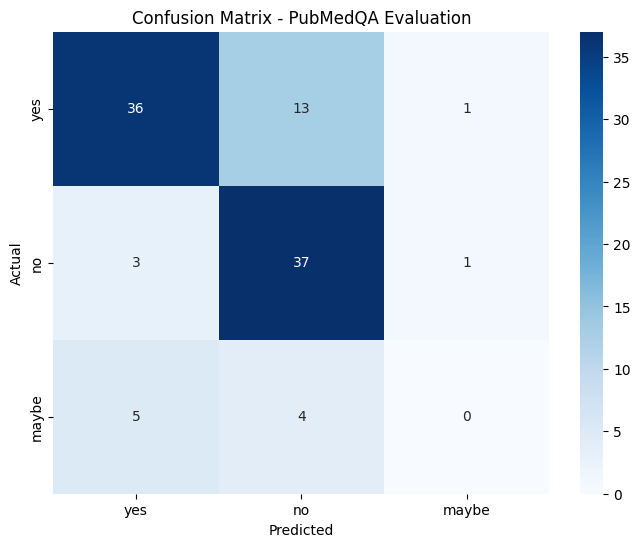

In [20]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_pubmedqa(model, tokenizer, dataset):
    """Evaluate the model on PubMedQA test set"""
    predictions = []
    references = []
    
    # Set model to evaluation mode
    model.eval()
    
    # Process each example in the test set
    for example in dataset:
        # Format the prompt
        prompt = f"<s>[INST] Context: {example['context']}\n\nQuestion: {example['question']} [/INST]"
        
        # Tokenize the prompt
        inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
        
        # Generate answer
        with torch.no_grad():
            outputs = model.generate(
                input_ids=inputs["input_ids"],
                attention_mask=inputs["attention_mask"],
                max_new_tokens=10,
                do_sample=False,
                pad_token_id=tokenizer.eos_token_id
            )
        
        # Decode the generated text
        generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
        
        # Extract the answer (yes/no/maybe)
        # The answer should be after the [/INST] token
        answer = generated_text.split("[/INST]")[-1].strip().lower()
        
        # Normalize the answer to match the expected format
        if "yes" in answer:
            pred = "yes"
        elif "no" in answer:
            pred = "no"
        elif "maybe" in answer:
            pred = "maybe"
        else:
            # If unclear, default to maybe
            pred = "maybe"
        
        predictions.append(pred)
        references.append(example["final_decision"].lower())
    
    # Calculate metrics
    accuracy = accuracy_score(references, predictions)
    f1 = f1_score(references, predictions, average="weighted")
    
    # Create confusion matrix
    cm = confusion_matrix(references, predictions, labels=["yes", "no", "maybe"])
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["yes", "no", "maybe"], yticklabels=["yes", "no", "maybe"])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix - PubMedQA Evaluation')
    plt.savefig('./pubmedqa_confusion_matrix.png')
    
    # Print metrics
    print(f"PubMedQA Evaluation Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    
    return {
        "accuracy": accuracy,
        "f1": f1,
        "confusion_matrix": cm
    }

# Evaluate on PubMedQA test set
pubmedqa_results = evaluate_pubmedqa(model, tokenizer, dataset["test"])

### Evaluation on MMLU

In [25]:
import numpy as np
from datasets import load_dataset
from tqdm import tqdm

def evaluate_mmlu_direct(model, tokenizer):
    """Evaluate the model on MMLU dataset with a direct implementation"""
    # Load the MMLU dataset
    mmlu_dataset = load_dataset("cais/mmlu", "all", split="test")
    
    # We'll focus on medical-related tasks
    medical_tasks = [
        "anatomy", "clinical_knowledge", "college_medicine", 
        "medical_genetics", "professional_medicine", "virology"
    ]
    
    # Filter for medical tasks
    medical_data = mmlu_dataset.filter(lambda x: x["subject"] in medical_tasks)
    
    # Limit to 50 examples for faster evaluation
    medical_data = medical_data.select(range(min(50, len(medical_data))))
    
    # Initialize results dictionary
    results = {}
    subject_results = {subject: {"correct": 0, "total": 0} for subject in medical_tasks}
    
    # Set model to evaluation mode
    model.eval()
    
    for example in tqdm(medical_data, desc="Evaluating MMLU"):
        # Format the prompt
        prompt = f"The following are multiple choice questions (with answers) about medical knowledge.\n\n"
        
        # Add the question and choices
        prompt += f"Question: {example['question']}\n"
        for i, choice in enumerate(example['choices']):
            prompt += f"{chr(65+i)}. {choice}\n"
        prompt += "Answer:"
        
        # Tokenize the prompt
        inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
        
        # Generate the answer
        with torch.no_grad():
            outputs = model.generate(
                input_ids=inputs["input_ids"],
                attention_mask=inputs["attention_mask"],
                max_new_tokens=5,
                do_sample=False,
                pad_token_id=tokenizer.eos_token_id
            )
        
        # Decode the generated text
        generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
        
        # Extract the answer (A, B, C, or D)
        answer = generated_text.split("Answer:")[-1].strip().upper()
        
        # Convert to index (0, 1, 2, or 3)
        if answer and answer[0] in ['A', 'B', 'C', 'D']:
            predicted_idx = ord(answer[0]) - ord('A')
        else:
            # Default to first choice if no clear answer
            predicted_idx = 0
        
        # Update results
        subject = example['subject']
        subject_results[subject]["total"] += 1
        if predicted_idx == example['answer']:
            subject_results[subject]["correct"] += 1
    
    # Calculate overall accuracy
    total_correct = sum([v["correct"] for v in subject_results.values()])
    total_total = sum([v["total"] for v in subject_results.values()])
    overall_accuracy = total_correct / total_total if total_total > 0 else 0
    
    # Calculate per-subject accuracy
    for subject in medical_tasks:
        if subject_results[subject]["total"] > 0:
            subject_accuracy = subject_results[subject]["correct"] / subject_results[subject]["total"]
            results[f"mmlu_{subject}"] = subject_accuracy
            print(f"{subject}: {subject_accuracy:.4f}")
    
    # Print overall accuracy
    print(f"\nOverall MMLU Accuracy: {overall_accuracy:.4f}")
    
    return {
        "accuracy": overall_accuracy,
        "subject_results": subject_results
    }

# Evaluate on MMLU
mmlu_results = evaluate_mmlu_direct(model, tokenizer)

Filter:   0%|          | 0/14042 [00:00<?, ? examples/s]

Evaluating MMLU: 100%|██████████| 50/50 [00:10<00:00,  4.56it/s]

anatomy: 0.5600

Overall MMLU Accuracy: 0.5600


### Inference

In [27]:
from transformers import pipeline

# Load the fine-tuned model
model_path = "./mistral-pubmedqa-finetune"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForCausalLM.from_pretrained(model_path)

# Create a text generation pipeline
qa_pipeline = pipeline("text-generation", model=model, tokenizer=tokenizer)

# Example question
context = "Recent studies have shown that regular physical activity can reduce the risk of cardiovascular disease by up to 35%."
question = "Does exercise reduce heart disease risk?"

# Format the prompt
prompt = f"<s>[INST] Context: {context}\n\nQuestion: {question} [/INST]"

# Generate answer
result = qa_pipeline(prompt, max_new_tokens=10, num_return_sequences=1)
print(result[0]['generated_text'])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

<s>[INST] Context: Recent studies have shown that regular physical activity can reduce the risk of cardiovascular disease by up to 35%.

Question: Does exercise reduce heart disease risk? [/INST] Yes, regular physical activity can help reduce the risk
